# Анализ лояльности пользователей Яндекс Афиши
---

### Цель проекта

Целью данного исследования является анализ лояльности пользователей сервиса **Яндекс Афиша**.
Команда маркетинга заинтересована в том, чтобы понять, **какие пользователи с большей вероятностью возвращаются на платформу и совершают повторные заказы**, а также какие факторы первого заказа и дальнейшего поведения связаны с удержанием клиентов.

Результаты исследования планируется использовать для:
- выявления перспективных сегментов пользователей;
- более точной настройки маркетинговых кампаний;
- оптимизации маркетинговых бюджетов;
- повышения общего уровня удержания пользователей сервиса.

### Задачи исследования
---

Для достижения поставленной цели в рамках проекта необходимо решить следующие задачи:

**1. Выгрузить данные из базы данных** Яндекс Афиши с использованием SQL и библиотеки SQLAlchemy, сформировав датасет, содержащий информацию о пользователях, заказах, мероприятиях и местах их проведения.

**2. Провести предобработку данных, включая:**
- проверку и обработку пропущенных значений;
- приведение типов данных к корректным форматам;
- перевод выручки из казахстанских тенге в российские рубли;
- анализ распределений числовых признаков и обработку выбросов.

**3. Сформировать профиль пользователя**, агрегировав данные по каждому пользователю и рассчитав признаки, характеризующие его поведение (количество заказов, среднюю выручку, средний интервал между покупками и др.).

**4. Провести исследовательский анализ данных (EDA)** с целью выявления факторов, влияющих на вероятность повторных заказов, включая:
- характеристики первого заказа;
- финансовые и количественные показатели заказов;
- временные параметры поведения пользователей.

**5. Выполнить корреляционный анализ** между признаками профиля пользователя и числом совершённых заказов с использованием коэффициента корреляции *phi_k*.

**6. Сформулировать выводы и рекомендации** для команды маркетинга на основе полученных результатов исследования.

### Подключение к базе данных

Для подключения к базе данных используются переменные окружения,
которые хранятся в файле `.env` (файл не включён в репозиторий).

Используемые переменные:

- **DB_HOST** — хост базы данных
- **DB_PORT** — порт подключения
- **DB_NAME** — имя базы данных
- **DB_USER** — имя пользователя
- **DB_PASSWORD** — пароль пользователя

Пример файла `.env`:

```env
DB_HOST=your_db_host
DB_PORT=6432
DB_NAME=data-analyst-afisha
DB_USER=your_user
DB_PASSWORD=your_password
```

---

### Описание датасета 

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


##  Загрузка данных и их предобработка

In [138]:
# Импорт необходимых библиотек
import os
from dotenv import load_dotenv
import pandas as pd
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
from phik import phik_matrix
import seaborn as sns


In [139]:
# Параметры подключения к базе данных
load_dotenv()

DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')

# Формирование строки подключения к PostgreSQL
connection_string = (
    f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
)

# Создание подключения (engine) к базе данных
engine = create_engine(connection_string)

In [140]:
# SQL-запрос для выгрузки данных
# 
# Логика запроса:
# 1. Отбираем заказы только с мобильных и десктопных устройств
# 2. Исключаем заказы на фильмы (event_type_main <> 'фильм')
# 3. Присоединяем информацию о мероприятиях, городах и регионах
# 4. С помощью оконной функции LAG рассчитываем дату предыдущего заказа пользователя
# 5. Вычисляем количество дней между текущим и предыдущим заказом (days_since_prev)

query = '''
WITH base AS (
    SELECT
        p.user_id,
        p.device_type_canonical,
        p.order_id,
        p.created_dt_msk,
        p.created_ts_msk,
        p.currency_code,
        p.revenue,
        p.tickets_count,
        p.event_id,
        p.service_name,
        e.event_name_code,
        e.event_type_main,
        e.city_id
    FROM afisha.purchases p
    JOIN afisha.events e ON p.event_id = e.event_id
    WHERE
        p.device_type_canonical IN ('mobile', 'desktop')
        AND e.event_type_main <> 'фильм'
),
base_with_lag AS (
    SELECT
        b.*,
        LAG(b.created_dt_msk::date) OVER (
            PARTITION BY b.user_id
            ORDER BY b.created_dt_msk::date
        ) AS prev_order_dt
    FROM base b
)
SELECT
    b.user_id,
    b.device_type_canonical,
    b.order_id,
    b.created_dt_msk AS order_dt,
    b.created_ts_msk AS order_ts,
    b.currency_code,
    b.revenue,
    b.tickets_count,
    (b.created_dt_msk::date - b.prev_order_dt) AS days_since_prev,
    b.event_id,
    b.event_name_code AS event_name,
    b.event_type_main,
    b.service_name,
    r.region_name,
    c.city_name
FROM base_with_lag b
JOIN afisha.city c ON b.city_id = c.city_id
JOIN afisha.regions r ON c.region_id = r.region_id
ORDER BY b.user_id;
''' 

In [141]:
# Выгружаем данные из базы данных в pandas DataFrame
df = pd.read_sql_query(query, con=engine)

---
### Изучение общей информации о данных

---

In [142]:
# Размер датафрейма
df.shape

(290611, 15)

In [143]:
# Общая информация о столбцах и типах данных
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  str           
 1   device_type_canonical  290611 non-null  str           
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[us]
 4   order_ts               290611 non-null  datetime64[us]
 5   currency_code          290611 non-null  str           
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  str           
 11  event_type_main        290611 non-null  str           
 12  service_name           290611 non-null  str           


In [144]:
# Просмотр первых и последних строк для проверки корректности выгрузки
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [145]:
df.tail()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Каменевский регион,Глиногорск
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Широковская область,Ягодиновка
290610,ffff00725179321,mobile,813654,2024-09-25,2024-09-25 15:12:40,rub,802.25,2,NaN,284965,58574140-962c-49a3-af70-b773a05661a3,концерты,Мой билет,Малиновоярский округ,Верховино


In [146]:
# Количество пропущенных значений по каждому столбцу
df.isna().sum()


user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
dtype: int64

In [147]:
# Описательная статистика для числовых признаков
df.describe()

,order_id,order_dt,order_ts,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611,290611,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,2024-09-01 22:36:38.741272,2024-09-02 13:31:19.397731,625.584360,2.754311,3.222381,438019.834992
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 00:00:42,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,2024-07-30 00:00:00,2024-07-30 11:53:37.500000,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,2024-09-12 00:00:00,2024-09-12 14:02:10,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,2024-10-09 00:00:00,2024-10-09 15:57:55.500000,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,2024-10-31 00:00:00,2024-10-31 23:59:54,81174.540000,57.000000,148.000000,592325.000000
std,2.497551e+06,NaN,NaN,1227.693064,1.170620,11.350509,147423.078841


In [148]:
# Проверим уникальность заказов
df['order_id'].nunique(), df.shape[0]

(290611, 290611)

In [149]:
# Проверим распределение валют
df['currency_code'].value_counts()

currency_code
rub    285542
kzt      5069
Name: count, dtype: int64

In [150]:
# Проверим типы устройств
df['device_type_canonical'].value_counts()

device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64

In [151]:
# Проверим типы мероприятий
df['event_type_main'].value_counts().head(10)

event_type_main
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: count, dtype: int64

**Промежуточный вывод по шагу 1. Изучение общей информации о данных**

В результате SQL-выгрузки был получен датасет из **290 611 строк и 15 столбцов**, содержащий информацию о пользователях, их заказах, мероприятиях и местах проведения событий. Каждая строка соответствует одному заказу, дубликаты заказов отсутствуют.

Типы данных в датафрейме в целом соответствуют ожидаемым:

- даты заказа (`order_dt`) и время заказа (`order_ts`) представлены в формате `datetime`;
- числовые показатели (`revenue`, `tickets_count`, `days_since_prev`) имеют числовые типы данных;
- категориальные признаки (тип устройства, валюта, тип мероприятия, регион и город) представлены строковыми значениями.

Пропущенные значения обнаружены только в столбце `days_since_prev` (**21 933 записи**), что соответствует ожиданиям: пропуски возникают у пользователей с единственным заказом. В остальных столбцах пропусков не выявлено.

В данных присутствуют заказы в двух валютах — **российские рубли и казахстанские тенге**, что требует приведения выручки к единой валюте на этапе предобработки. Также в распределении выручки и количества билетов наблюдаются потенциальные выбросы (в том числе отрицательные значения выручки и заказы с большим числом билетов), которые необходимо дополнительно проанализировать.

В целом выгрузка данных выполнена корректно, объём и структура датасета достаточны для дальнейшего анализа лояльности пользователей.


---

## Предобработка данных

---

### Приведение выручки к рублям

---


In [152]:
tenge_df = pd.read_csv(
    'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
)

# Приводим дату к datetime
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

# Оставляем только нужные столбцы
tenge_df = tenge_df[['data', 'curs']]

In [153]:
# Объединяем основной датасет с таблицей курсов по дате заказа
df = df.merge(
    tenge_df,
    left_on='order_dt',
    right_on='data',
    how='left'
)

# Создаём новый столбец revenue_rub:
# - если валюта RUB — оставляем значение выручки без изменений
# - если валюта KZT — переводим по курсу (курс указан за 100 тенге)
df['revenue_rub'] = df.apply(
    lambda row: row['revenue']
    if row['currency_code'] == 'rub'
    else row['revenue'] * row['curs'] / 100,
    axis=1
)


# Проверим результат
df[['currency_code', 'revenue', 'revenue_rub']].head(100)


,currency_code,revenue,revenue_rub
0,rub,1521.94,1521.940000
1,rub,289.45,289.450000
2,rub,1258.57,1258.570000
3,rub,8.49,8.490000
4,rub,1390.41,1390.410000
...,...,...,...
95,rub,47.56,47.560000
96,kzt,328.77,61.148261
97,rub,103.20,103.200000
98,rub,824.54,824.540000


In [154]:
# Удаляем лишние колонки
cols_to_drop = ['data','curs']

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Проверим результат
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


**Промежуточный вывод по шагу 2.1. Приведение выручки к рублям**

Для приведения выручки к единой валюте был использован датасет с курсами казахстанского тенге к российскому рублю за 2024 год. Курс указан в рублях за 100 тенге.

Данные о курсах были объединены с основным датасетом по дате заказа. На основе валюты оплаты был рассчитан новый столбец `revenue_rub`:
- для заказов в рублях значение выручки оставлено без изменений;
- для заказов в тенге выполнён пересчёт по соответствующему курсу.

После расчёта выручки в рублях вспомогательные столбцы с датами и курсами были удалены, так как они не используются в дальнейшем анализе.

В результате датасет содержит корректный и сопоставимый показатель выручки (`revenue_rub`), который будет использоваться на следующих этапах исследования.


---

### Проверка пропусков

---

In [155]:
# Проверка пропусков по столбцам
na_counts = df.isna().sum().sort_values(ascending=False)
na_share = (df.isna().mean() * 100).round(2)

display(pd.DataFrame({'na_count': na_counts, 'na_%': na_share}).query('na_count > 0'))


,na_count,na_%
days_since_prev,21933,7.55


В датафрейме обнаружены пропущенные значения только в столбце `days_since_prev`.
Количество пропусков составляет 21 933 записи (7.55% от общего числа строк).

Данные пропуски являются ожидаемыми и корректными, так как возникают у пользователей,
совершивших только один заказ, для которых невозможно вычислить интервал между покупками.
В остальных столбцах пропущенные значения отсутствуют.

---
### Приведение типов данных
---

In [156]:
# Текущая информация о типах данных и потреблении памяти
df.info(memory_usage='deep')


<class 'pandas.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  str           
 1   device_type_canonical  290611 non-null  str           
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[us]
 4   order_ts               290611 non-null  datetime64[us]
 5   currency_code          290611 non-null  str           
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  str           
 11  event_type_main        290611 non-null  str           
 12  service_name           290611 non-null  str           


In [157]:
# Список категориальных столбцов
cat_cols = [
    'device_type_canonical',
    'currency_code',
    'event_type_main',
    'service_name',
    'region_name',
    'city_name'
]

for col in cat_cols:
    df[col] = df[col].astype('category')
    
# order_id и event_id можно сузить
df['order_id'] = df['order_id'].astype('int32')
df['event_id'] = df['event_id'].astype('int32')

# tickets_count — достаточно int16
df['tickets_count'] = df['tickets_count'].astype('int16')

# дни между покупками и выручка — float32
df['days_since_prev'] = df['days_since_prev'].astype('float32')
df['revenue'] = df['revenue'].astype('float32')
df['revenue_rub'] = df['revenue_rub'].astype('float32')

df.info(memory_usage='deep')

<class 'pandas.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  str           
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[us]
 4   order_ts               290611 non-null  datetime64[us]
 5   currency_code          290611 non-null  category      
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int16         
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  str           
 11  event_type_main        290611 non-null  category      
 12  service_name           290611 non-null  category      


В рамках предобработки были оптимизированы типы данных с целью снижения
потребления памяти и повышения эффективности дальнейшего анализа.

Номинальные признаки (тип устройства, валюта, тип мероприятия, билетный оператор,
регион и город) были приведены к типу `category`.
Числовые идентификаторы и количественные показатели были приведены
к более компактным типам (`int32`, `int16`, `float32`).

В результате объём памяти, занимаемый датафреймом, сократился
с ~216 МБ до ~60 МБ без потери информации.

---
### Изучение значений в ключевых столбцах (поиск ошибок)
---


In [158]:
# Смотрим базовую статистику по выручке (в исходной валюте и в рублях)
df[['revenue', 'revenue_rub']].describe()

,revenue,revenue_rub
count,290611.000000,290611.000000
mean,625.584351,555.571960
std,1227.693115,875.498169
min,-90.760002,-90.760002
25%,116.849998,113.970001
50%,356.010010,351.140015
75%,810.130005,802.049988
max,81174.539062,81174.539062


In [159]:
# Считаем, сколько заказов с нулевой или отрицательной выручкой (в рублях)
# Такие значения могут быть связаны с возвратами/отменами/промо и не обязательно являются ошибкой.
non_positive_revenue_count = (df['revenue_rub'] <= 0).sum()
non_positive_revenue_share = (non_positive_revenue_count / len(df) * 100).round(2)

print('Заказов с revenue_rub <= 0:', non_positive_revenue_count)
print('Доля заказов с revenue_rub <= 0 (%):', non_positive_revenue_share)

Заказов с revenue_rub <= 0: 5907
Доля заказов с revenue_rub <= 0 (%): 2.03


In [160]:
# Примеры таких заказов
df.loc[df['revenue_rub'] <= 0, ['currency_code', 'revenue', 'revenue_rub']].head(10)

,currency_code,revenue,revenue_rub
24,rub,0.00,0.00
65,rub,0.00,0.00
66,rub,0.00,0.00
67,rub,0.00,0.00
68,rub,0.00,0.00
252,rub,-2.37,-2.37
517,rub,0.00,0.00
519,rub,0.00,0.00
695,rub,0.00,0.00
696,rub,0.00,0.00


In [161]:
# Статистика по количеству билетов
df['tickets_count'].describe()

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

**Изучение значений в ключевых столбцах и поиск ошибок**

В рамках данного шага были проанализированы ключевые числовые показатели датасета — выручка с заказа (`revenue`, `revenue_rub`) и количество билетов в заказе (`tickets_count`).

Анализ распределения выручки показал следующее:

- Средняя выручка с заказа в рублях составляет около **556 ₽**, медианное значение — **351 ₽**, что указывает на правостороннее асимметричное распределение.
- В данных присутствуют заказы с **нулевой и отрицательной выручкой**: **5 907 заказов**, что составляет **около 2,03%** от общего числа наблюдений.
- Отрицательные и нулевые значения выручки, вероятно, связаны с **возвратами, отменами заказов или корректировками**, и не являются ошибками выгрузки, однако требуют отдельного внимания при дальнейшем анализе.
- Максимальные значения выручки достигают **81 174 ₽**, что указывает на наличие потенциальных выбросов.

Анализ количества билетов в заказе показал:

- Минимальное количество билетов в заказе — **1**, что соответствует бизнес-логике сервиса.
- Медианное значение — **3 билета**, среднее — около **2,75 билета**.
- Максимальное значение — **57 билетов в одном заказе**, что может указывать на **групповые или корпоративные заказы** и требует дополнительной проверки на этапе анализа выбросов.

В целом, значения в ключевых числовых столбцах выглядят **логичными и согласованными с предметной областью**. Существенных ошибок в данных не выявлено, однако:
- значения `revenue_rub <= 0` необходимо учитывать отдельно;
- распределение выручки содержит выраженные выбросы, которые будут обработаны на следующем этапе с использованием фильтрации по **99-му перцентилю**.


---
### Проверка категориальных признаков на "мусор" / псевдопропуски / нормализацию
---


In [162]:
# Список категориальных столбцов, которые важны для анализа сегментов
cat_cols = [
    'device_type_canonical',
    'currency_code',
    'event_type_main',
    'service_name',
    'region_name',
    'city_name',
]

# Для каждого столбца:
# 1) смотрим топ-значения по частоте
# 2) оцениваем количество уникальных значений (чтобы понять "размерность" признака)
for col in cat_cols:
    print(f'\n--- {col} ---')
    print('Уникальных значений:', df[col].nunique())
    display(df[col].value_counts().head(15))

city_name
Глиногорск      89446
Озёрск          43910
Радужсвет       13711
Радужнополье     8741
Верховино        6579
Дальнесветск     6293
Глинополье       6196
Светополье       5993
Глиноград        5934
Лесоярич         5831
Озёрчане         4790
Островецк        4722
Кристалевск      4690
Родниковецк      4568
Горнодолинск     3926
Name: count, dtype: int64

In [163]:
# Проверка категориальных столбцов на наличие "пустых строк"
# Иногда вместо NaN в данных могут встречаться пустые строки '',
# что считается ошибкой качества данных и требует очистки.
empty_strings = (df[cat_cols] == '').sum().sort_values(ascending=False)
display(empty_strings[empty_strings > 0])


# Проверка категориальных признаков на наличие служебных значений,
# которые часто используются для обозначения отсутствия данных
# (например: 'unknown', 'none', 'nan', '-', 'нет данных' и т.п.)
suspects = {
    'unknown',
    'none',
    'nan',
    '-',
    'неизвестно',
    'нет данных',
    'нет',
    'n/a'
}

for col in cat_cols:
    # Приводим значения к строковому типу, убираем пробелы
    # и переводим в нижний регистр для корректного сравнения
    col_lower = df[col].astype(str).str.strip().str.lower()
    
    found = col_lower.isin(suspects).sum()
    
    if found > 0:
        print(f'В столбце "{col}" обнаружено подозрительных значений: {found}')


Series([], dtype: int64)

**Проверка категориальных признаков**

В рамках этапа предобработки были проанализированы ключевые категориальные признаки, используемые для сегментации пользователей и дальнейшего исследования лояльности:

- `device_type_canonical`
- `currency_code`
- `event_type_main`
- `service_name`
- `region_name`
- `city_name`

Для каждого признака были изучены:
- количество уникальных значений;
- распределение значений по частоте;
- наличие псевдопропусков и «мусорных» категорий.

**Результаты анализа**

- Признаки `device_type_canonical` и `currency_code` содержат ограниченное число корректных категорий (по 2 значения каждый) и не требуют дополнительной обработки.
- Признак `event_type_main` представлен 7 осмысленными категориями мероприятий (концерты, театр, спорт и другие). Категорий, обозначающих отсутствие данных, не выявлено.
- Признак `service_name` содержит 36 уникальных значений — названия билетных операторов. Все значения выглядят валидными и отражают реальных партнёров сервиса.
- Географические признаки `region_name` (81 значение) и `city_name` (352 значения) обладают высокой размерностью, что ожидаемо для федерального сервиса. Некорректных или служебных значений не обнаружено.

Дополнительно была выполнена проверка:
- на наличие пустых строк (`''`) вместо `NaN`;
- на наличие служебных значений, часто используемых для обозначения отсутствия данных (`unknown`, `none`, `nan`, `-`, `нет данных` и т.п.).

По результатам проверки пустые строки и псевдопропуски в категориальных столбцах не выявлены.

**Вывод:**  
Категориальные признаки очищены, нормализованы и не требуют дополнительной обработки. Данные готовы к дальнейшему анализу и построению пользовательских профилей.


---
### Анализ распределений числовых признаков и обработка выбросов
---

In [164]:
# Числовые признаки, важные для анализа лояльности
num_cols = ['revenue_rub', 'tickets_count']

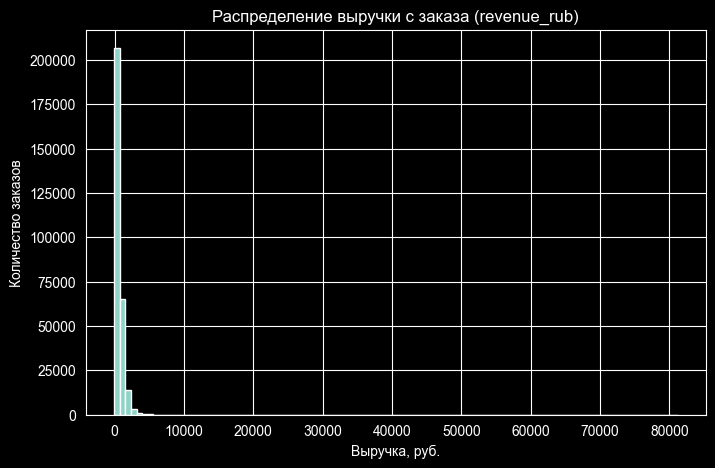

In [165]:
# Гистограмма распределения выручки в рублях
plt.figure(figsize=(8, 5))
plt.hist(df['revenue_rub'], bins=100)
plt.title('Распределение выручки с заказа (revenue_rub)')
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество заказов')
plt.show()

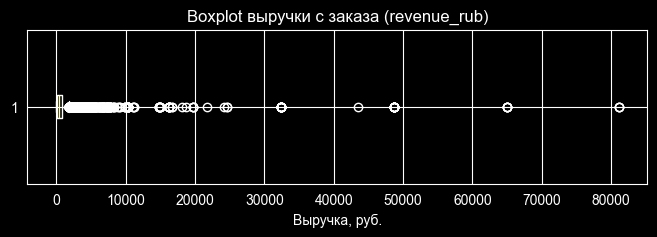

In [166]:
# Boxplot для выручки
plt.figure(figsize=(8, 2))
plt.boxplot(df['revenue_rub'], vert=False)
plt.title('Boxplot выручки с заказа (revenue_rub)')
plt.xlabel('Выручка, руб.')
plt.show()


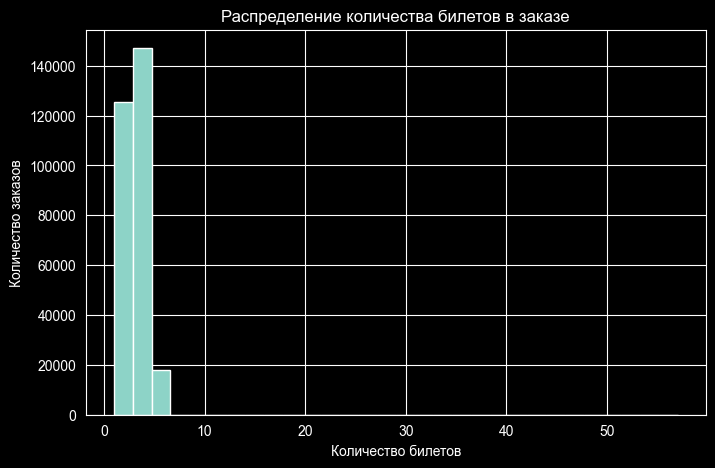

In [167]:
# Гистограмма распределения количества билетов
plt.figure(figsize=(8, 5))
plt.hist(df['tickets_count'], bins=30)
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов')
plt.ylabel('Количество заказов')
plt.show()

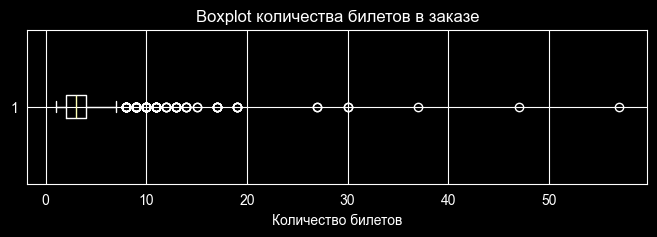

In [168]:
# Boxplot для количества билетов
plt.figure(figsize=(8, 2))
plt.boxplot(df['tickets_count'], vert=False)
plt.title('Boxplot количества билетов в заказе')
plt.xlabel('Количество билетов')
plt.show()


In [169]:
# Рассчитываем 99-й перцентиль выручки
revenue_99 = df['revenue_rub'].quantile(0.99)
revenue_99


np.float64(2628.421630859375)

In [170]:
# Количество строк до фильтрации
before_filter = df.shape[0]

# Фильтруем выбросы по 99 перцентилю
df_filtered = df[df['revenue_rub'] <= revenue_99].copy()

# Количество строк после фильтрации
after_filter = df_filtered.shape[0]

# Сколько строк удалено
filtered_count = before_filter - after_filter
filtered_share = round(filtered_count / before_filter * 100, 2)

before_filter, after_filter, filtered_count, filtered_share


(290611, 287786, 2825, 0.97)

In [171]:
# Описательная статистика до и после фильтрации
df[['revenue_rub']].describe(), df_filtered[['revenue_rub']].describe()


(         revenue_rub
 count  290611.000000
 mean      555.571960
 std       875.498169
 min       -90.760002
 25%       113.970001
 50%       351.140015
 75%       802.049988
 max     81174.539062,
          revenue_rub
 count  287786.000000
 mean      518.029236
 std       511.963776
 min       -90.760002
 25%       111.849998
 50%       343.849991
 75%       788.659973
 max      2628.421631)

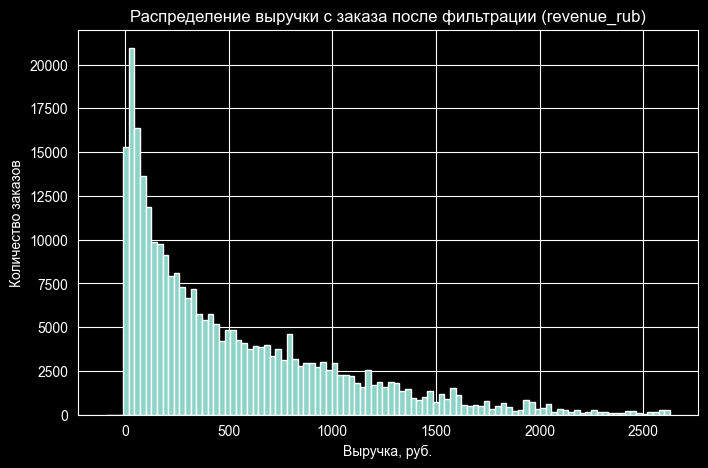

In [172]:
# Гистограмма распределения выручки ПОСЛЕ фильтрации выбросов
plt.figure(figsize=(8, 5))
plt.hist(df_filtered['revenue_rub'], bins=100)
plt.title('Распределение выручки с заказа после фильтрации (revenue_rub)')
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество заказов')
plt.show()

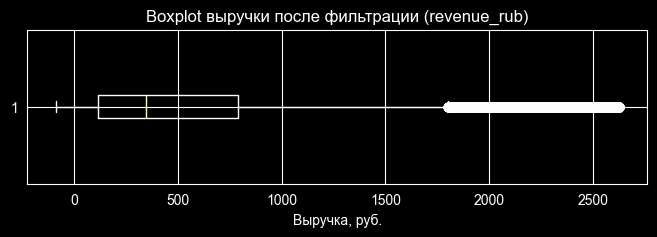

In [173]:
# Boxplot выручки ПОСЛЕ фильтрации выбросов
plt.figure(figsize=(8, 2))
plt.boxplot(df_filtered['revenue_rub'], vert=False)
plt.title('Boxplot выручки после фильтрации (revenue_rub)')
plt.xlabel('Выручка, руб.')
plt.show()


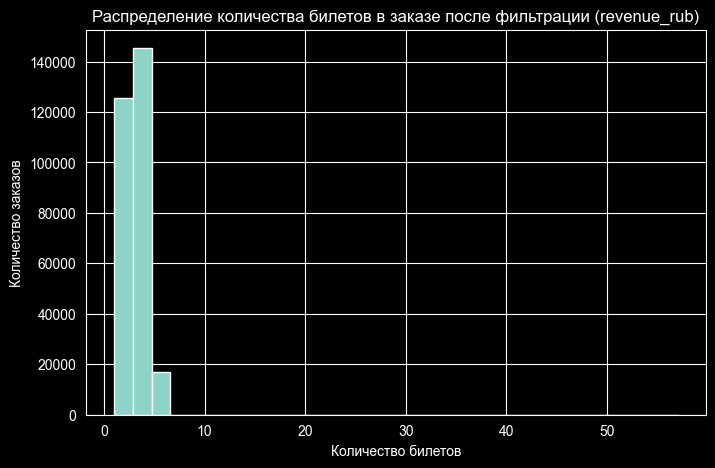

In [174]:
# Гистограмма распределения количества билетов ПОСЛЕ фильтрации выбросов
plt.figure(figsize=(8, 5))
plt.hist(df_filtered['tickets_count'], bins=30)
plt.title('Распределение количества билетов в заказе после фильтрации (revenue_rub)')
plt.xlabel('Количество билетов')
plt.ylabel('Количество заказов')
plt.show()

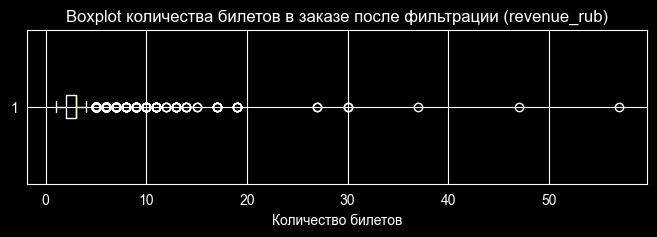

In [175]:
# Boxplot для количества билетов ПОСЛЕ фильтрации выбросов
plt.figure(figsize=(8, 2))
plt.boxplot(df_filtered['tickets_count'], vert=False)
plt.title('Boxplot количества билетов в заказе после фильтрации (revenue_rub)')
plt.xlabel('Количество билетов')
plt.show()


**Анализ распределений числовых признаков и обработка выбросов**

В рамках предобработки были проанализированы числовые признаки, наиболее важные для оценки поведения и лояльности пользователей:

- **выручка с заказа в рублях (`revenue_rub`)**;
- **количество билетов в заказе (`tickets_count`)**.

---

**Распределение выручки (`revenue_rub`)**

Анализ гистограммы и boxplot показал, что распределение выручки имеет выраженную правостороннюю асимметрию:

- основная масса заказов сосредоточена в диапазоне до нескольких тысяч рублей;
- присутствует длинный «хвост» редких заказов с очень высокой выручкой (десятки тысяч рублей);
- встречаются нулевые и отрицательные значения выручки, что может быть связано с возвратами, отменами заказов или корректировками и не является ошибкой выгрузки.

Для снижения влияния экстремальных значений на дальнейший анализ было принято решение отфильтровать выбросы по **99-му перцентилю**.

- значение 99-го перцентиля выручки составило **≈ 2 628 руб.**;
- все заказы с `revenue_rub` выше этого значения были исключены из анализа.

---

**Эффект фильтрации**

- количество заказов до фильтрации: **290 611**;
- количество заказов после фильтрации: **287 786**;
- отфильтровано заказов: **2 825**;
- доля отфильтрованных данных: **≈ 0,97%**.

Таким образом, фильтрация затронула менее 1% наблюдений и не привела к существенной потере данных, при этом значительно снизив влияние выбросов на статистические показатели.

После фильтрации:

- средняя выручка снизилась;
- стандартное отклонение стало существенно меньше;
- максимальное значение выручки ограничено разумным уровнем.

---

**Распределение количества билетов (`tickets_count`)**

Распределение количества билетов в заказе характеризуется следующими особенностями:

- основная масса заказов содержит от **2 до 4 билетов**;
- встречаются редкие заказы с большим количеством билетов (до 57), однако такие значения логически возможны (групповые покупки);
- явных ошибок или аномалий, требующих фильтрации, не обнаружено.

В связи с этим фильтрация по `tickets_count` **не применялась**.

---

**Итог**

- Выручка с заказа (`revenue_rub`) была приведена к устойчивому распределению путём фильтрации выбросов по 99-му перцентилю.
- Количество билетов (`tickets_count`) сохранено без изменений.
- Подготовленный датасет (`df_filtered`) является более устойчивым к выбросам и пригоден для дальнейшего анализа и построения пользовательских профилей.


---
### Общий вывод по разделу 2. Предобработка данных

В рамках раздела «Предобработка данных» была проведена комплексная подготовка исходного датасета к дальнейшему анализу пользовательского поведения и лояльности.

**Основные выполненные шаги**

**1. Приведение выручки к единой валюте**
Выручка по всем заказам была приведена к рублям с использованием официальных курсов тенге за 2024 год. Для этого:

- данные о курсах были объединены с основным датасетом по дате заказа;
- для заказов в рублях выручка сохранена без изменений;
- для заказов в тенге выполнён корректный пересчёт по курсу;
- сформирован единый сопоставимый показатель revenue_rub, используемый далее в анализе.

**2. Проверка пропусков**
Пропущенные значения обнаружены только в столбце days_since_prev (7,55% записей).
Данные пропуски являются ожидаемыми и соответствуют пользователям с единственным заказом, для которых невозможно вычислить интервал между покупками. В остальных столбцах пропуски отсутствуют.

**3. Оптимизация типов данных**
Для повышения эффективности анализа и снижения потребления памяти:

- номинальные признаки приведены к типу category;
- числовые идентификаторы и количественные показатели приведены к более компактным типам (int32, int16, float32);
- объём памяти, занимаемый датафреймом, сокращён с ~216 МБ до ~60 МБ без потери информации.

**4. Анализ ключевых числовых показателей**
Проведена проверка значений выручки и количества билетов:

- выявлены нулевые и отрицательные значения выручки (≈2% заказов), которые интерпретируются как возвраты или корректировки и не считаются ошибками;
- подтверждена логичность распределения количества билетов (медиана — 3 билета, максимум — 57 билетов).

**5. Проверка категориальных признаков**
Проанализированы признаки, используемые для сегментации:

- не выявлено пустых строк, псевдопропусков или служебных значений;
- все категории выглядят валидными и соответствуют предметной области;
- дополнительная нормализация категориальных данных не потребовалась.

**6. Анализ распределений и обработка выбросов**
Анализ распределения выручки выявил сильную правостороннюю асимметрию и наличие экстремальных значений.
Для снижения влияния выбросов:

- выполнена фильтрация заказов по 99-му перцентилю revenue_rub;
- удалено менее 1% наблюдений (≈0,97%), что не привело к существенной потере данных;
- распределение выручки стало более устойчивым для дальнейшего анализа.

Признак `tickets_count` дополнительно проверен после фильтрации и не требует очистки, так как значения остаются логически корректными.

**Итог**

В результате предобработки:

- сформирован чистый и согласованный датасет;
- выручка приведена к единой валюте;
- данные оптимизированы по памяти;
- устранено влияние экстремальных выбросов;
- подготовлен устойчивый датасет `df_filtered`, пригодный для дальнейшего анализа лояльности, сегментации пользователей и построения аналитических моделей.

---

---

## Создание профиля пользователя
---

### Построение профиля пользователя
---


In [176]:
# Работаем с датасетом после фильтрации выбросов
df_work = df_filtered.copy()

# Сортируем по пользователю и времени заказа
df_work = df_work.sort_values(['user_id', 'order_ts'])


In [177]:
# Агрегация поведенческих метрик пользователя
user_agg = (
    df_work
    .groupby('user_id')
    .agg(
        first_order_dt=('order_ts', 'min'),        # дата первого заказа
        last_order_dt=('order_ts', 'max'),         # дата последнего заказа
        orders_count=('order_id', 'nunique'),      # общее число заказов
        avg_revenue_rub=('revenue_rub', 'mean'),   # средняя выручка с заказа
        avg_tickets_count=('tickets_count', 'mean'),  # среднее число билетов
        avg_days_between_orders=('days_since_prev', 'mean')  # среднее время между заказами
    )
    .reset_index()
)

user_agg.head()


,user_id,first_order_dt,last_order_dt,orders_count,avg_revenue_rub,avg_tickets_count,avg_days_between_orders
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,1,1521.939941,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,2,774.010010,3.000000,75.0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,3,767.213379,2.666667,51.0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,1,917.830017,4.000000,NaN
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,2,61.309998,1.500000,16.0


In [178]:
# Берём первый заказ каждого пользователя
first_orders = (
    df_work
    .drop_duplicates(subset='user_id', keep='first')
    .loc[:, [
        'user_id',
        'device_type_canonical',
        'region_name',
        'service_name',
        'event_type_main'
    ]]
)

# Переименовываем признаки
first_orders = first_orders.rename(columns={
    'device_type_canonical': 'first_device',
    'region_name': 'first_region',
    'service_name': 'first_service',
    'event_type_main': 'first_event_type'
})

first_orders.head()


,user_id,first_device,first_region,first_service,first_event_type
0,0002849b70a3ce2,mobile,Каменевский регион,Край билетов,театр
1,0005ca5e93f2cf4,mobile,Каменевский регион,Мой билет,выставки
3,000898990054619,mobile,Североярская область,Лови билет!,другое
6,00096d1f542ab2b,desktop,Каменевский регион,Край билетов,театр
7,000a55a418c128c,mobile,Поленовский край,Лучшие билеты,театр


In [179]:
# Объединяем агрегаты и признаки первого заказа
user_profile = user_agg.merge(
    first_orders,
    on='user_id',
    how='left'
)

In [180]:
# Пользователь сделал 2 и более заказов
user_profile['is_two'] = (user_profile['orders_count'] >= 2).astype('int8')

# Пользователь сделал 5 и более заказов
user_profile['is_five'] = (user_profile['orders_count'] >= 5).astype('int8')

user_profile[['orders_count', 'is_two', 'is_five']].head(10)


,orders_count,is_two,is_five
0,1,0,0
1,2,1,0
2,3,1,0
3,1,0,0
4,2,1,0
5,13,1,1
6,2,1,0
7,1,0,0
8,1,0,0
9,3,1,0


In [181]:
# Финальный профиль пользователя
user_profile.head()

,user_id,first_order_dt,last_order_dt,orders_count,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,first_device,first_region,first_service,first_event_type,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,1,1521.939941,4.000000,NaN,mobile,Каменевский регион,Край билетов,театр,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,2,774.010010,3.000000,75.0,mobile,Каменевский регион,Мой билет,выставки,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,3,767.213379,2.666667,51.0,mobile,Североярская область,Лови билет!,другое,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,1,917.830017,4.000000,NaN,desktop,Каменевский регион,Край билетов,театр,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,2,61.309998,1.500000,16.0,mobile,Поленовский край,Лучшие билеты,театр,1,0


---
### Оценка репрезентативности и качества профилей
---

In [182]:
# Общее число пользователей
total_users = user_profile['user_id'].nunique()

# Средняя выручка с заказа (по пользователям)
avg_revenue_per_order = user_profile['avg_revenue_rub'].mean()

# Доли повторных пользователей
share_two_plus = user_profile['is_two'].mean() * 100
share_five_plus = user_profile['is_five'].mean() * 100

total_users, avg_revenue_per_order, share_two_plus, share_five_plus


(21854,
 np.float32(544.3981),
 np.float64(61.709526860071385),
 np.float64(29.00613160062231))

In [183]:
# Статистика по числу заказов
user_profile['orders_count'].describe()


count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10181.000000
Name: orders_count, dtype: float64

In [184]:
# Статистика по среднему числу билетов
user_profile['avg_tickets_count'].describe()


count    21854.000000
mean         2.743129
std          0.913080
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max         11.000000
Name: avg_tickets_count, dtype: float64

In [185]:
# Статистика по среднему времени между заказами
user_profile['avg_days_between_orders'].describe()


count    13513.000000
mean        15.851275
std         22.306225
min          0.000000
25%          1.000000
50%          8.000000
75%         20.428572
max        148.000000
Name: avg_days_between_orders, dtype: float64

In [186]:
# Посмотрим самые большие значения
user_profile['orders_count'].sort_values(ascending=False).head(10)


981      10181
2054      4351
11073     4021
5414      3791
10810     3710
2330      3503
6776      3375
14765     3249
15502     3138
17634     3036
Name: orders_count, dtype: int64

In [187]:
user_profile['avg_tickets_count'].sort_values(ascending=False).head(10)


8840     11.000000
6410     10.000000
2360     10.000000
1400      9.000000
10113     8.666667
19825     8.000000
4702      7.000000
2843      7.000000
8978      7.000000
1402      7.000000
Name: avg_tickets_count, dtype: float64

На основе агрегированных профилей пользователей была проведена оценка объёма выборки, распределений ключевых показателей и наличия аномалий.

---

**Общие характеристики выборки**

- Общее число пользователей: 21 854
- Средняя выручка с одного заказа: ≈ 544 ₽
- Доля пользователей с 2 и более заказами: ≈ 61,7%
- Доля пользователей с 5 и более заказами: ≈ 29,0%

Полученные значения указывают на высокий уровень повторных покупок: более половины пользователей совершают как минимум два заказа, а почти треть — пять и более.

---

**Распределение количества заказов**

Статистика по числу заказов на пользователя:

- медиана — 2 заказа;
- 75% пользователей совершают не более 5 заказов;
- при этом присутствуют пользователи с экстремально высоким числом заказов (максимум — 10 181 заказ).

Среднее значение (≈13 заказов) существенно превышает медиану, что указывает на сильную правостороннюю асимметрию распределения. Это означает наличие небольшой группы сверхактивных пользователей, которые значительно влияют на средние показатели.

Такие значения могут быть связаны с:

- корпоративными или групповыми покупками;
- профессиональными организаторами мероприятий;
- пользователями с особыми сценариями использования сервиса.

---

**Среднее количество билетов в заказе**

Распределение среднего числа билетов на пользователя выглядит устойчивым:

- медиана — 2,75 билета;
- 75% пользователей покупают в среднем до 3 билетов;
- максимальное значение — 11 билетов.

Экстремальные значения встречаются редко и логически объяснимы (групповые покупки), поэтому не рассматриваются как ошибки данных.

---

**Среднее время между заказами**

Для пользователей с повторными заказами рассчитан средний интервал между покупками:

- медианное значение — 8 дней;
- 75% пользователей совершают повторную покупку в течение ≈20 дней;
- максимальный средний интервал — 148 дней.

Распределение также асимметрично, однако значения находятся в разумных временных пределах и соответствуют различным пользовательским сценариям (спонтанные покупки vs редкие посещения мероприятий).

---

**Оценка аномалий и решение по фильтрации**

В данных присутствуют экстремальные значения по числу заказов и некоторым агрегированным метрикам, однако:
- такие пользователи составляют незначительную долю выборки;
- значения не противоречат бизнес-логике сервиса;
- данные являются репрезентативными для реального поведения пользователей.

**Решение:**
На данном этапе фильтрация пользовательских профилей не применяется. Аномальные значения сохраняются и будут учитываться при дальнейшем анализе, при необходимости — через сегментацию или отдельный анализ чувствительности.

**Вывод**
Построенные профили пользователей:

- обладают достаточным объёмом и репрезентативностью;
- отражают разнообразные сценарии пользовательского поведения;
- не содержат критических аномалий или ошибок.

Датасет профилей пользователей готов к дальнейшему исследовательскому анализу факторов, влияющих на возврат пользователей и их лояльность.

---

## Исследовательский анализ данных


---

### Исследование признаков первого заказа и их связи с возвращением на платформу

---

#### Распределение пользователей по признакам.


In [188]:
# Общий размер выборки (кол-во пользователей)
total_users = user_profile['user_id'].nunique()

# Список признаков "первого заказа", по которым будем строить сегменты
first_order_cols = [
    'first_event_type',      # тип первого мероприятия
    'first_device',     # устройство первого заказа
    'first_region',     # регион первого заказа
    'first_service'     # билетный оператор первого заказа
]

def segment_distribution(df: pd.DataFrame, col, top_n=None) -> pd.DataFrame:
    """
    Считает распределение пользователей по сегментам.
    
    Args:
        df (pd.DataFrame): датафрейм с профилями пользователей
        col (str): колонка, по которой строим сегменты
        top_n (int | None): если задано — выводим только топ-N сегментов по числу пользователей

    Returns:
        pd.DataFrame: таблица с сегментом, числом пользователей и долей
    """
    dist = (
        df.groupby(col, dropna=False)['user_id']
        .nunique()
        .rename('users_cnt')
        .reset_index()
        .sort_values('users_cnt', ascending=False)
    )

    # Доля пользователей в каждом сегменте
    dist['users_share_%'] = (dist['users_cnt'] / total_users * 100).round(2)

    # Если сегментов слишком много — ограничиваем вывод
    if top_n is not None:
        dist = dist.head(top_n)

    return dist

# 1) Тип первого мероприятия
dist_event_type = segment_distribution(user_profile, 'first_event_type')
display(dist_event_type)

# 2) Устройство первого заказа
dist_device = segment_distribution(user_profile, 'first_device')
display(dist_device)

# 3) Регион первого заказа (много категорий — покажем топ-10)
dist_region = segment_distribution(user_profile, 'first_region', top_n=10)
display(dist_region)

# 4) Билетный оператор первого заказа (много категорий — покажем топ-10)
dist_service = segment_distribution(user_profile, 'first_service', top_n=10)
display(dist_service)


,first_service,users_cnt,users_share_%
3,Билеты без проблем,5223,23.90
22,Мой билет,2992,13.69
19,Лови билет!,2848,13.03
4,Билеты в руки,2594,11.87
23,Облачко,2194,10.04
7,Весь в билетах,1304,5.97
20,Лучшие билеты,1188,5.44
24,Прачечная,588,2.69
17,Край билетов,459,2.10
12,Дом культуры,358,1.64


В рамках анализа были изучены признаки, описывающие **первый заказ пользователя**, так как именно они формируют «точку входа» на платформу и потенциально влияют на дальнейшее поведение.

Рассмотрены следующие признаки:

- тип первого мероприятия;
- устройство первого заказа;
- регион первого заказа;
- билетный оператор первого заказа.

Для каждого признака было рассчитано количество пользователей и их доля в общей выборке.

---

**Тип первого мероприятия**

Распределение пользователей по типу первого мероприятия неравномерное:

- **концерты** — 44,1% пользователей;
- **другое** — 25,1%;
- **театр** — 19,6%;
- остальные категории (стендап, спорт, выставки, ёлки) суммарно составляют менее 11%.

**Выраженная точка входа — концерты**, на них приходится почти половина всех первых заказов.

--- 

**Устройство первого заказа**

Распределение по устройствам резко смещено в сторону мобильных устройств:

- **mobile** — 82,9%;
- **desktop** — 17,1%.

Пользователи преимущественно начинают взаимодействие с сервисом с **мобильных устройств**, что указывает на мобильный сценарий как основной входной канал.

---

**Регион первого заказа**

Распределение по регионам также сильно неравномерное:

 - **Каменевский регион** — 32,8%;
 - **Североярская область** — 17,4%;
 - остальные регионы имеют доли менее 6% каждый.

Наблюдается высокая концентрация пользователей в нескольких ключевых регионах, что говорит о наличии географических точек входа.

---

**Билетный оператор первого заказа**

Сегментация по билетным операторам показывает явных лидеров:

 - **«Билеты без проблем»** — 23,9%;
 - **«Мой билет»** — 13,7%;
 - **«Лови билет!»** — 13,0%;
 - **«Билеты в руки»** — 11,9%.

Несколько операторов формируют основную массу первых заказов, остальные играют второстепенную роль.

---

Распределение пользователей по признакам первого заказа **не является равномерным**. Во всех рассмотренных разрезах наблюдаются выраженные «точки входа»:

 - концерты — ключевой тип первого мероприятия;
 - мобильные устройства — основной канал входа;
 - несколько крупных регионов формируют значительную долю аудитории;
 - ограниченное число билетных операторов привлекает большинство новых пользователей.

Эти сегменты представляют наибольший интерес для дальнейшего анализа возвратов и проверки гипотез о повторных покупках.

---

#### Анализ возврата пользователей


In [189]:
# Средняя доля пользователей с 2+ заказами по всей выборке
baseline_return_rate = user_profile['is_two'].mean() * 100
baseline_return_rate

np.float64(61.709526860071385)

In [190]:
def segment_return_rate(
    df: pd.DataFrame,
    col,
    top_n=None
) -> pd.DataFrame:
    """
    Считает долю пользователей с 2+ заказами по сегментам.

    Args:
        df (pd.DataFrame): датафрейм с профилями пользователей
        col (str): признак сегментации
        top_n (int | None): если задано — оставить только топ-N сегментов по числу пользователей

    Returns:
        pd.DataFrame: сегмент, кол-во пользователей, доля возвратов
    """
    res = (
        df.groupby(col)
        .agg(
            users_cnt=('user_id', 'nunique'),
            return_rate=('is_two', 'mean')
        )
        .reset_index()
    )

    res['return_rate_%'] = (res['return_rate'] * 100).round(2)

    # сортируем по доле возвратов
    res = res.sort_values('return_rate', ascending=False)

    if top_n is not None:
        res = res.head(top_n)

    return res


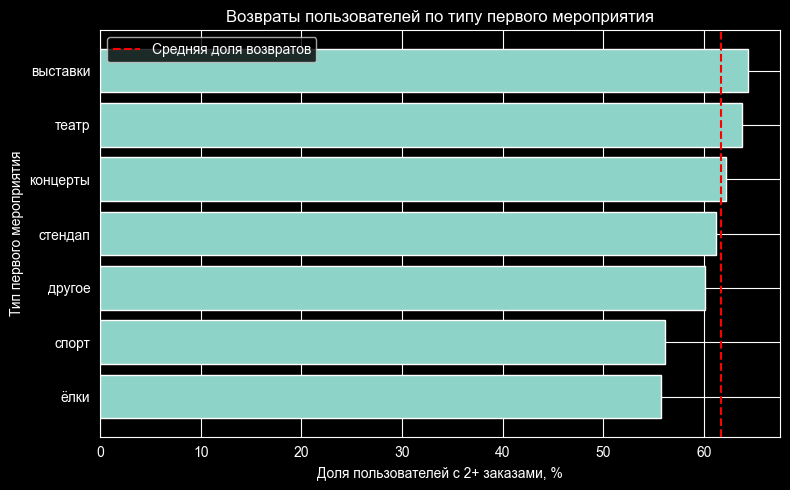

In [191]:
# Тип первого мероприятия
ret_event_type = segment_return_rate(user_profile, 'first_event_type')
display(ret_event_type)


plt.figure(figsize=(8, 5))
plt.barh(
    ret_event_type['first_event_type'],
    ret_event_type['return_rate_%']
)

# Средняя линия по выборке
plt.axvline(
    baseline_return_rate,
    color='red',
    linestyle='--',
    label='Средняя доля возвратов'
)

plt.xlabel('Доля пользователей с 2+ заказами, %')
plt.ylabel('Тип первого мероприятия')
plt.title('Возвраты пользователей по типу первого мероприятия')
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

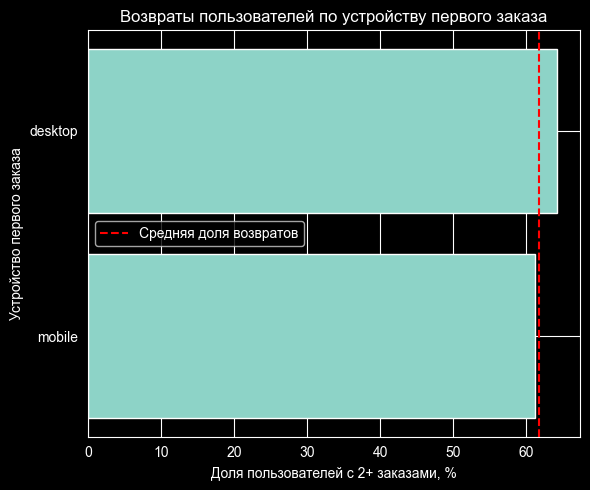

In [192]:
# Устройство первого заказа
ret_device = segment_return_rate(user_profile, 'first_device')
display(ret_device)


plt.figure(figsize=(6, 5))
plt.barh(
    ret_device['first_device'],
    ret_device['return_rate_%']
)

plt.axvline(
    baseline_return_rate,
    color='red',
    linestyle='--',
    label='Средняя доля возвратов'
)

plt.xlabel('Доля пользователей с 2+ заказами, %')
plt.ylabel('Устройство первого заказа')
plt.title('Возвраты пользователей по устройству первого заказа')
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

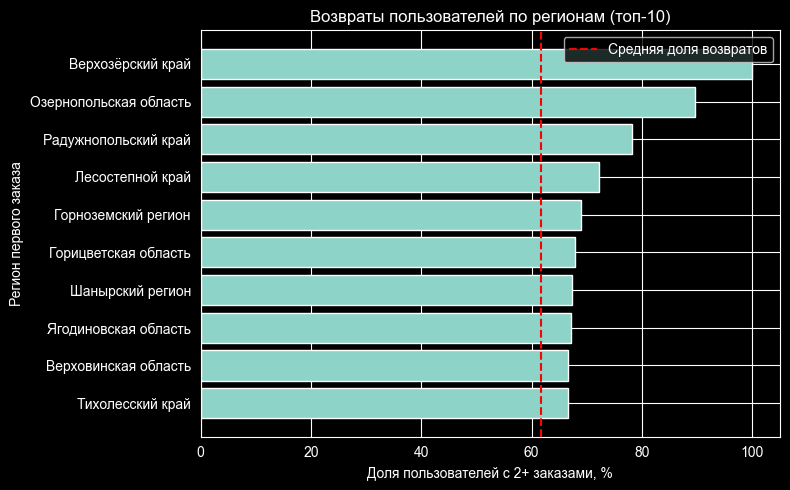

In [193]:
# Регион первого заказа (топ-10)
ret_region = segment_return_rate(user_profile, 'first_region', top_n=10)
display(ret_region)


plt.figure(figsize=(8, 5))
plt.barh(
    ret_region['first_region'],
    ret_region['return_rate_%']
)

plt.axvline(
    baseline_return_rate,
    color='red',
    linestyle='--',
    label='Средняя доля возвратов'
)

plt.xlabel('Доля пользователей с 2+ заказами, %')
plt.ylabel('Регион первого заказа')
plt.title('Возвраты пользователей по регионам (топ-10)')
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

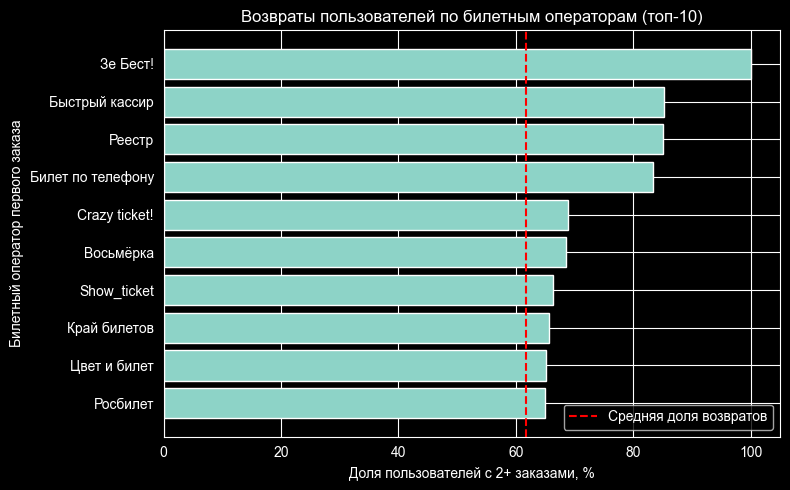

In [194]:
# Билетный оператор первого заказа (топ-10)
ret_service = segment_return_rate(user_profile, 'first_service', top_n=10)
display(ret_service)


plt.figure(figsize=(8, 5))
plt.barh(
    ret_service['first_service'],
    ret_service['return_rate_%']
)

plt.axvline(
    baseline_return_rate,
    color='red',
    linestyle='--',
    label='Средняя доля возвратов'
)

plt.xlabel('Доля пользователей с 2+ заказами, %')
plt.ylabel('Билетный оператор первого заказа')
plt.title('Возвраты пользователей по билетным операторам (топ-10)')
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

В рамках данного этапа была проанализирована доля пользователей, **совершивших два и более заказа**, в разрезе сегментов, сформированных на основе признаков первого заказа. В качестве базового ориентира использовалась средняя доля возвратов по всей выборке.

**Средняя доля пользователей с 2+ заказами по выборке:
≈ 61,7%**

---

**Возвраты по типу первого мероприятия**

Анализ показал, что вероятность повторного заказа зависит от типа мероприятия, на которое пользователь приобрёл билет впервые.

Наиболее высокая доля возвратов наблюдается у пользователей, чей первый заказ был связан с:

 - **выставками** (~64,4%);
 - **театром** (~63,8%);
 - **концертами** (~62,2%).

Эти сегменты демонстрируют показатели выше **среднего уровня по выборке**.
Пользователи, начавшие с **спортивных мероприятий** и **ёлок**, возвращаются заметно реже (≈56–55%), что ниже среднего уровня.

Таким образом, **культурные мероприятия** (театр, выставки, концерты) можно рассматривать как более успешные «точки входа» с точки зрения удержания пользователей.

---

**Возвраты по устройству первого заказа**

Пользователи, совершившие первый заказ с десктопных устройств, возвращаются чаще:

 - **desktop** — ≈64,1%;
 - **mobile*** — ≈61,2%.

Разница не является критической, однако десктоп демонстрирует **устойчиво более высокую долю повторных покупок** по сравнению со средним значением.

Это может указывать на более осознанное или планируемое поведение пользователей при покупке с десктопа.

---

**Возвраты по региону первого заказа**

При анализе регионов были рассмотрены только **топ-10 регионов** с наибольшим числом пользователей.

Визуально наблюдаются регионы с крайне высокой долей возвратов (до 100%), однако:

 - такие значения относятся к сегментам **с очень малым числом пользователей** (1–10 человек);
 - подобные показатели являются **нестабильными и статистически ненадёжными**.

Среди регионов с **достаточным объёмом пользователей** (сотни человек) доля возвратов находится в диапазоне ≈**66–68%**, что немного выше среднего по выборке.

Вывод: для регионального признака **объём сегмента критически важен** при интерпретации результатов. Надёжные выводы возможны только для крупных регионов.

---

**Возвраты по билетному оператору первого заказа**

Анализ топ-10 билетных операторов по числу пользователей показал:

 - У отдельных операторов наблюдается очень высокая доля возвратов (80–100%), однако:
    - такие значения в основном характерны для операторов **с десятками или единицами пользователей**;
 - Среди операторов с крупными сегментами (сотни пользователей):
    - доля возвратов находится в диапазоне **≈65–69%**;
    - показатели чаще всего **превышают средний уровень по выборке**.

Это указывает на то, что **крупные билетные партнёры в целом формируют лояльную аудиторию**, однако для небольших операторов выводы требуют осторожности.

---

Возврат пользователей **не является равномерным** и зависит от характеристик первого заказа.
**Успешные точки входа** с точки зрения удержания:
 - культурные мероприятия (театр, выставки, концерты);
 - покупки с десктопных устройств.
Анализ по регионам и билетным операторам необходимо интерпретировать с учётом **размера сегментов**, так как малые группы дают нестабильные показатели.
Полученные результаты подтверждают, что признаки первого заказа могут быть **информативными факторами** при построении модели прогнозирования возврата пользователей.

---
#### Проверка продуктовых гипотез

На основе анализа распределения пользователей и долей возвратов по сегментам первого заказа были проверены продуктовые гипотезы о факторах, влияющих на повторные покупки.


**Гипотеза 1**

***Тип мероприятия влияет на вероятность возврата на платформу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие первый заказ на концерты.***

Проверка гипотезы
Сравним долю пользователей с двумя и более заказами:
**концерты** — ≈ 62,2%;
**спорт** — ≈ 56,2%.

Гипотеза **не подтверждается.**

Пользователи, начавшие с **концертов**, возвращаются **чаще**, чем пользователи, чей первый заказ был связан со **спортивными мероприятиями**. Более того, спортивные мероприятия демонстрируют одну из самых низких долей возвратов среди рассмотренных типов событий.

Таким образом, тип первого мероприятия действительно влияет на вероятность повторной покупки, однако **направление влияния противоположно заявленному в гипотезе**.

---

**Гипотеза 2**

***В регионах с наибольшим числом пользователей доля повторных заказов выше, чем в менее активных регионах.***

При анализе регионов сегменты были **отсортированы по доле пользователей с двумя и более заказами**. В анализ были включены **10 регионов с наибольшей долей возвратов**, без предварительного ограничения по числу пользователей.

Наблюдения показали, что:
 - максимальные значения доли возвратов (80–100%) характерны для регионов **с очень малым числом пользователей** (единицы или десятки человек);
 - такие значения являются **нестабильными и статистически ненадёжными** и не могут использоваться для обобщающих выводов;
 - в регионах **с более крупными пользовательскими сегментами** (сотни пользователей) доля возвратов находится в диапазоне ≈**66–68%,** что выше среднего уровня по выборке (≈**61,7%**).

Гипотеза **частично подтверждается**.

Действительно, между регионами наблюдаются различия в доле повторных заказов. Однако экстремально высокие значения возвратов обусловлены преимущественно **малым объёмом данных** и не отражают устойчивых закономерностей.

Для регионов с достаточным числом пользователей доля возвратов стабильно превышает среднее значение по выборке, что указывает на возможное влияние регионального фактора на вероятность повторной покупки. При этом интерпретация результатов требует обязательного учёта размера сегмента.


---

###  Исследование поведения пользователей через показатели выручки и состава заказа

---

#### Связь между средней выручкой сервиса с заказа и повторными заказами.


In [195]:
# Группа 1: пользователи с ровно 1 заказом
one_order = user_profile.loc[user_profile['orders_count'] == 1, 'avg_revenue_rub']

# Группа 2: пользователи с 2+ заказами (вернувшиеся)
two_plus = user_profile.loc[user_profile['orders_count'] >= 2, 'avg_revenue_rub']


plt.figure(figsize=(10, 5))

# Одинаковые бины для обеих гистограмм — важно для сравнения
bins = 40

plt.hist(
    one_order,
    bins=bins,
    density=True,
    alpha=0.5,
    label='1 заказ'
)

plt.hist(
    two_plus,
    bins=bins,
    density=True,
    alpha=0.5,
    label='2+ заказов'
)

plt.title('4.2.1 Распределение средней выручки с заказа (avg_revenue_rub)')
plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.legend()
plt.tight_layout()
plt.show()

# Дополнительно: базовые статистики для двух групп
display(one_order.describe())
display(two_plus.describe())

count    13486.000000
mean       543.841064
std        366.645721
min         -5.385000
25%        274.112518
50%        497.621964
75%        739.353348
max       2628.421631
Name: avg_revenue_rub, dtype: float64

В рамках данного этапа была изучена связь между средней выручкой сервиса с заказа (`avg_revenue_rub`) и фактом возврата пользователя (совершение 2 и более заказов).

Для анализа пользователи были разделены на две группы:
 - пользователи, совершившие **ровно 1 заказ**;
 - пользователи, совершившие **2 и более заказов**.

Для обеих групп были построены сравнительные гистограммы распределения средней выручки с заказа с одинаковыми интервалами (`bins`) и нормировкой (`density=True`), что позволило корректно сопоставить формы распределений при разном размере выборок.

**Наблюдения по распределениям**

Пользователи с одним заказом:
 - медиана: ≈ **378** руб.
 - межквартильный диапазон (25–75%): ≈ **132 – 830** руб.
 - распределение более растянутое, с высокой дисперсией;
 - заметно больше пользователей с низкой средней выручкой.

Пользователи с 2 и более заказами:
 - медиана: ≈ **498** руб.
 - межквартильный диапазон (25–75%): ≈ **274 – 739** руб.
 - распределение более компактное;
 - основная масса пользователей сосредоточена в средних ценовых диапазонах.

При этом среднее значение средней выручки практически не отличается:
 - 1 заказ — ≈ **545** руб.
 - 2+ заказов — ≈ **544** руб.

Это указывает на то, что именно среднее значение не является показателем различий между группами — различия проявляются в **форме распределений**, а не в среднем.

**Сравнение групп**
Пользователи, которые возвращаются на платформу, в среднем совершают **более дорогие первые заказы**, чем пользователи с одним заказом (что отражается в более высокой медиане).
Пользователи с одним заказом чаще встречаются в сегменте **низкой средней выручки**, что может указывать на менее вовлечённое или случайное поведение.
У вернувшихся пользователей распределение более стабильное и сконцентрированное, без сильного перекоса в сторону очень низких значений.

**Вывод**

Средняя выручка с заказа связана с вероятностью повторной покупки не напрямую через среднее значение, а через структуру распределения:
 - пользователи с более низкой средней выручкой чаще совершают только один заказ;
 - пользователи с более высокой и стабильной средней выручкой чаще возвращаются на платформу.

Таким образом, avg_revenue_rub может рассматриваться как информативный признак вовлечённости, который потенциально полезен при построении модели прогнозирования возврата пользователей.


---

#### Сравнение распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.


In [196]:
# Группа 1: пользователи с 2–4 заказами
orders_2_4 = user_profile.loc[
    (user_profile['orders_count'] >= 2) & (user_profile['orders_count'] <= 4),
    'avg_revenue_rub'
]

# Группа 2: пользователи с 5+ заказами
orders_5_plus = user_profile.loc[
    user_profile['orders_count'] >= 5,
    'avg_revenue_rub'
]


plt.figure(figsize=(10, 5))

bins = 40

plt.hist(
    orders_2_4,
    bins=bins,
    density=True,
    alpha=0.5,
    label='2–4 заказа'
)

plt.hist(
    orders_5_plus,
    bins=bins,
    density=True,
    alpha=0.5,
    label='5+ заказов'
)

plt.title('4.2.2 Распределение средней выручки с заказа\n(2–4 заказа vs 5+ заказов)')
plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.legend()
plt.tight_layout()
plt.show()


display(orders_2_4.describe())
display(orders_5_plus.describe())

count    6339.000000
mean      535.124390
std       294.615112
min         0.000000
25%       336.966324
50%       513.559998
75%       690.016083
max      2299.868896
Name: avg_revenue_rub, dtype: float64

Для анализа пользователи с повторными заказами были разделены на две группы:

- **2–4 заказа**
- **5 и более заказов**

Для обеих групп были построены сравнительные гистограммы распределения средней выручки с заказа (`avg_revenue_rub`) с одинаковыми интервалами и нормировкой, а также рассчитаны описательные статистики.

---

**Наблюдения по распределениям**

- Оба распределения имеют выраженную правостороннюю асимметрию и длинный «хвост» высоких значений.
- Основная масса пользователей в обеих группах сосредоточена в диапазоне **≈300–700 руб.** средней выручки с заказа.
- Распределение пользователей с **5+ заказами** более компактное и сосредоточено вокруг среднего значения.
- У пользователей с **2–4 заказами** распределение более растянуто и имеет более выраженный хвост высоких значений.

---

**Сравнение статистических показателей**

| Метрика | 2–4 заказа | 5+ заказов |
|------|-----------|-----------|
| Среднее | ≈ 551.6 руб. | ≈ 535.1 руб. |
| Медиана | ≈ 471.3 руб. | ≈ 513.6 руб. |
| 75-й перцентиль | ≈ 798.5 руб. | ≈ 690.0 руб. |
| Стандартное отклонение | ≈ 420.2 | ≈ 294.6 |

---

**Интерпретация**

- Медиана средней выручки с заказа выше у пользователей с **5+ заказами**, что указывает на более стабильный и предсказуемый размер заказа.
- Среднее значение немного выше у группы с **2–4 заказами** за счёт редких, но очень дорогих заказов.
- Пользователи с высокой лояльностью (5+ заказов) не совершают существенно более дорогие заказы, однако их поведение характеризуется большей однородностью.

---

**Вывод**

Значимых различий по уровню средней выручки с заказа между пользователями с **2–4** и **5+** заказами **не выявлено**.

Рост лояльности выражается не в увеличении среднего чека, а прежде всего в **стабильности покупательского поведения и частоте заказов**.


---

#### Влияние среднего количества билетов в заказе на вероятность повторной покупки


In [197]:
plt.figure(figsize=(8, 4))

plt.hist(
    user_profile['avg_tickets_count'],
    bins=30,
    alpha=0.7
)

plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по avg_tickets_count')
plt.tight_layout()
plt.show()

# Базовые статистики
user_profile['avg_tickets_count'].describe()

count    21854.000000
mean         2.743129
std          0.913080
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max         11.000000
Name: avg_tickets_count, dtype: float64

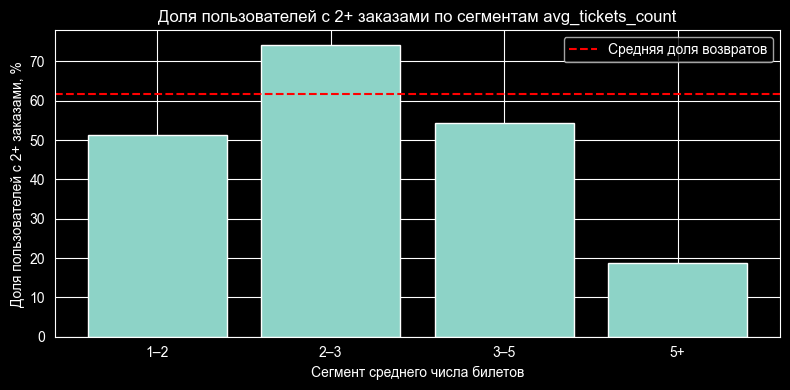

In [198]:
# Копия профиля пользователей для сегментации
tmp = user_profile.copy()

# Сегментация по условиям:
# 1–2, 2–3, 3–5, 5+
# Используем right=False, чтобы границы читались логично:
# [1,2), [2,3), [3,5), [5, inf)
tmp['tickets_segment'] = pd.cut(
    tmp['avg_tickets_count'],
    bins=[1, 2, 3, 5, float('inf')],
    right=False,
    labels=['1–2', '2–3', '3–5', '5+']
)

segment_stats = (
    tmp.groupby('tickets_segment', dropna=False)
    .agg(
        users_cnt=('user_id', 'nunique'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
)

segment_stats['return_rate_%'] = (segment_stats['return_rate'] * 100).round(2)
segment_stats['users_share_%'] = (segment_stats['users_cnt'] / tmp['user_id'].nunique() * 100).round(2)

display(segment_stats)

# Визуализация доли возвратов по сегментам
baseline_return_rate = user_profile['is_two'].mean() * 100

plt.figure(figsize=(8, 4))
plt.bar(segment_stats['tickets_segment'].astype(str), segment_stats['return_rate_%'])

plt.axhline(
    baseline_return_rate,
    color='red',
    linestyle='--',
    label='Средняя доля возвратов'
)

plt.title('Доля пользователей с 2+ заказами по сегментам avg_tickets_count')
plt.xlabel('Сегмент среднего числа билетов')
plt.ylabel('Доля пользователей с 2+ заказами, %')
plt.legend()
plt.tight_layout()
plt.show()


В рамках данного этапа была проанализирована связь между **средним количеством билетов в заказе** (`avg_tickets_count`) и вероятностью возврата пользователя (совершения 2 и более заказов).

Пользователи были разделены на следующие сегменты по среднему числу билетов в заказе:
 - **1–2 билета**
 - **2–3 билета**
 - **3–5 билетов**
 - **5 и более билетов**

Для каждого сегмента было рассчитано:
- количество пользователей;
- доля пользователей, совершивших повторные заказы (2+);
- доля сегмента в общей выборке.

---

**Распределение пользователей по сегментам**

Распределение пользователей по сегментам не является равномерным:
 - сегменты **2–3 билета** и **3–5 билетов** доминируют и суммарно охватывают около **86%** всех пользователей;
 - сегмент **1–2 билета** составляет около **11%** выборки;
 - сегмент **5+ билетов** является наименьшим и включает лишь около **3%** пользователей.

Таким образом, основная масса пользователей покупает в среднем от **2 до 5 билетов** за заказ.

---

**Возвраты пользователей по сегментам**

Анализ доли пользователей с повторными заказами показал существенные различия между сегментами:

- **2–3 билета** — **≈74.2%** пользователей совершают повторные покупки (значительно выше среднего уровня по выборке);
- **3–5 билетов** — **≈54.3%**, ниже среднего значения;
- **1–2 билета** — **≈51.3%**, одна из самых низких долей возвратов;
- **5+ билетов** — **≈18.8%**, аномально низкая доля повторных заказов.

Средняя доля пользователей с 2+ заказами по выборке составляет **≈61.7%**.

---

**Интерпретация результатов**

- Наиболее **лояльным сегментом** являются пользователи, покупающие в среднем **2–3 билета за заказ**.
- Пользователи с **1–2 билетами** чаще совершают разовые покупки и значительно реже возвращаются на платформу.
- Сегмент **5+ билетов** демонстрирует аномально низкую долю повторных заказов, что может быть связано с:
  - разовыми групповыми покупками;
  - корпоративными или событийными заказами;
  - специфическим сценарием использования сервиса, не предполагающим регулярных покупок.
- Увеличение среднего количества билетов **не приводит к росту лояльности**: после оптимального диапазона (2–3 билета) вероятность возврата снижается.

---

**Вывод**

Среднее количество билетов в заказе оказывает **нелинейное влияние** на вероятность повторной покупки.

- Оптимальным с точки зрения удержания является сегмент **2–3 билета**.
- Как слишком малые, так и слишком большие заказы ассоциированы с более низкой вероятностью возврата.
- Признак `avg_tickets_count` является **информативным фактором вовлечённости** и может быть полезен при построении модели прогнозирования возврата пользователей.


---

### Исследование временных характеристик первого заказа и их влияния на повторные покупки

---

#### Как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.


In [199]:
# День недели: 0 — понедельник, 6 — воскресенье
user_profile['first_order_weekday'] = user_profile['first_order_dt'].dt.dayofweek

weekday_map = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}

user_profile['first_order_weekday_name'] = (
    user_profile['first_order_weekday']
    .map(weekday_map)
)


In [200]:
weekday_stats = (
    user_profile
    .groupby('first_order_weekday_name')
    .agg(
        users_cnt=('user_id', 'nunique'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
)

weekday_stats['return_rate_%'] = (weekday_stats['return_rate'] * 100).round(2)
weekday_stats['users_share_%'] = (
    weekday_stats['users_cnt'] / user_profile['user_id'].nunique() * 100
).round(2)


weekday_stats = weekday_stats.sort_values('return_rate_%', ascending=False)

display(weekday_stats)





,first_order_weekday_name,users_cnt,return_rate,return_rate_%,users_share_%
5,Суббота,3459,0.642382,64.24,15.83
2,Понедельник,2943,0.632008,63.20,13.47
4,Среда,3072,0.623698,62.37,14.06
1,Вторник,3189,0.620571,62.06,14.59
0,Воскресенье,2810,0.604982,60.50,12.86
3,Пятница,3261,0.598589,59.86,14.92
6,Четверг,3120,0.595192,59.52,14.28


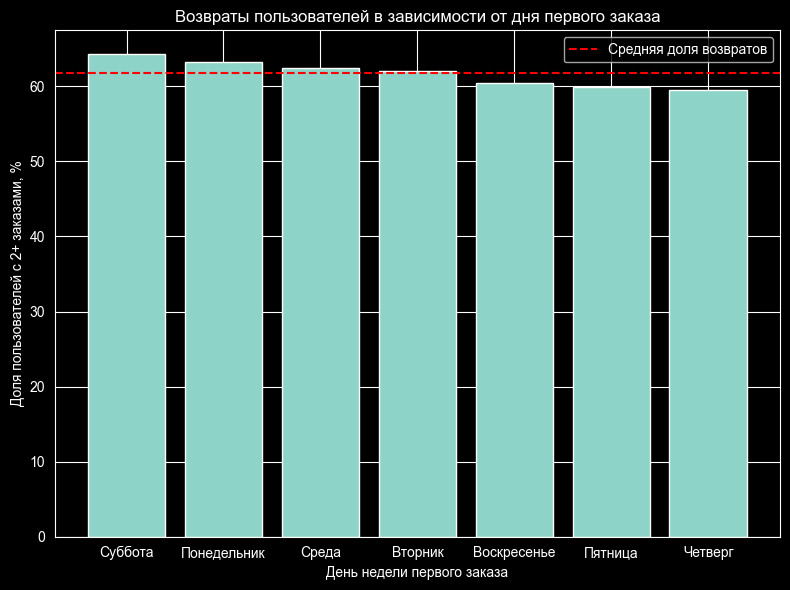

In [201]:
baseline_return_rate = user_profile['is_two'].mean() * 100

plt.figure(figsize=(8, 6))

plt.bar(
    weekday_stats['first_order_weekday_name'],
    weekday_stats['return_rate_%']
)

plt.axhline(
    baseline_return_rate,
    color='red',
    linestyle='--',
    label='Средняя доля возвратов'
)

plt.xlabel('День недели первого заказа')
plt.ylabel('Доля пользователей с 2+ заказами, %')
plt.title('Возвраты пользователей в зависимости от дня первого заказа')
plt.legend()
plt.tight_layout()
plt.show()

В рамках данного этапа было проанализировано, влияет ли день недели, в который пользователь совершил **первый заказ**, на вероятность его возврата на платформу (совершение 2 и более заказов).

Для анализа по дате первого заказа был выделен день недели, после чего для каждого дня были рассчитаны:
 - общее число пользователей;
 - доля пользователей, совершивших повторные заказы.

В качестве ориентира использовалась **средняя доля возвратов по всей выборке** — **≈ 61,7%**.

---

**Наблюдения**

- Максимальная доля возвратов наблюдается у пользователей, совершивших первый заказ в **субботу** (≈ 64,2%).
- Заказы, оформленные в **понедельник–среду**, также демонстрируют показатели **выше среднего уровня** по выборке.
- Минимальные значения возвратов характерны для **четверга и пятницы** (≈ 59,5–59,9%), однако отклонения от среднего остаются умеренными.
- Разброс долей возвратов между днями недели не превышает **≈ 4,7 п.п.**, что указывает на отсутствие резких различий.

---

**Вывод**

День недели первого заказа оказывает **незначительное влияние** на вероятность возврата пользователя.

Небольшое преимущество наблюдается у пользователей, начавших взаимодействие с платформой в **выходные дни** и в начале недели, однако в целом различия между днями недели **не являются существенными**.

Таким образом, день недели первого заказа **не может рассматриваться как сильный самостоятельный фактор удержания**, но может использоваться как дополнительный вспомогательный признак в модели прогнозирования возврата пользователей.


---

#### Влияние интервала между заказами на удержание клиентов.


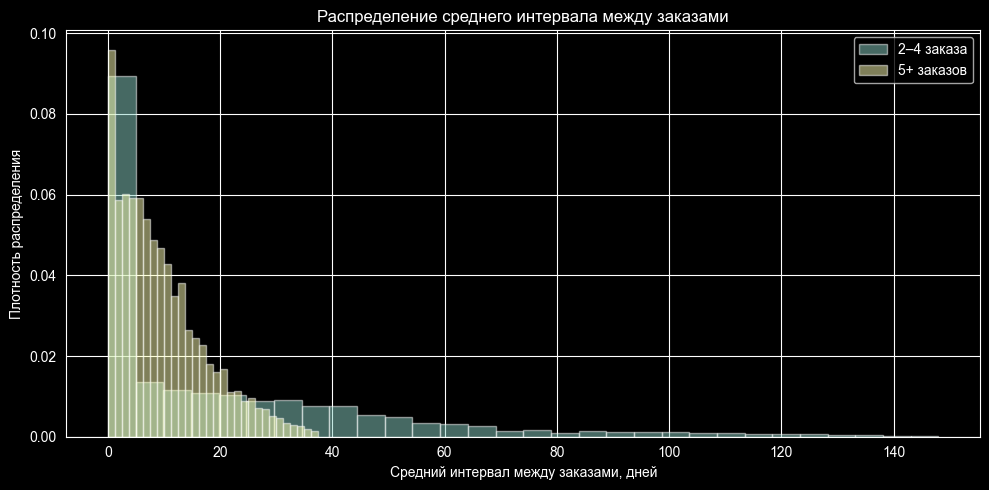

In [202]:
# Пользователи с 2–4 заказами
users_2_4 = user_profile.loc[
    user_profile['orders_count'].between(2, 4),
    'avg_days_between_orders'
]

# Пользователи с 5+ заказами
users_5_plus = user_profile.loc[
    user_profile['orders_count'] >= 5,
    'avg_days_between_orders'
]


display(users_2_4.describe())
display(users_5_plus.describe())


plt.figure(figsize=(10, 5))

bins = 30

plt.hist(
    users_2_4,
    bins=bins,
    density=True,
    alpha=0.5,
    label='2–4 заказа'
)

plt.hist(
    users_5_plus,
    bins=bins,
    density=True,
    alpha=0.5,
    label='5+ заказов'
)

plt.xlabel('Средний интервал между заказами, дней')
plt.ylabel('Плотность распределения')
plt.title('Распределение среднего интервала между заказами')
plt.legend()
plt.tight_layout()
plt.show()


В рамках данного этапа было проанализировано, как средний интервал между заказами (`avg_days_between_orders`) связан с удержанием пользователей.

Для анализа были рассмотрены пользователи с повторными покупками, которые были разделены на две группы:
 - пользователи, совершившие **2–4 заказа**;
 - пользователи, совершившие **5 и более заказов**.

Для обеих групп были построены сравнительные распределения среднего интервала между заказами с одинаковыми интервалами и нормировкой, а также рассчитаны описательные статистики.

---

**Наблюдения по распределениям**

- В обеих группах распределения имеют выраженную правостороннюю асимметрию и длинный «хвост» больших значений.
- У пользователей с **5 и более заказами** интервалы между покупками заметно **короче**, чем у пользователей с 2–4 заказами.
- Основная масса пользователей с 5+ заказами совершает покупки с интервалом **до 10–15 дней**.
- У пользователей с 2–4 заказами распределение более растянуто, а интервалы между заказами чаще превышают **20–30 дней**.

---

**Сравнение статистических показателей**

| Метрика | 2–4 заказа | 5+ заказов |
|------|-----------|-----------|
| Средний интервал | ≈ **21.3 дня** | ≈ **9.6 дня** |
| Медиана | **9 дней** | **7.8 дня** |
| 75-й перцентиль | **34 дня** | **13.8 дня** |
| Максимум | **148 дней** | **37.5 дня** |
| Стандартное отклонение | **28.5** | **7.9** |

---

**Интерпретация**

- Пользователи с **5 и более заказами** совершают покупки значительно **регулярнее**, что отражается в меньшем среднем и медианном интервале между заказами.
- Поведение пользователей с 2–4 заказами менее стабильное: они чаще делают длительные паузы между покупками.
- Большой разброс и наличие экстремальных значений в группе 2–4 заказов указывает на более эпизодическое использование сервиса.

---

**Вывод**

Средний интервал между заказами оказывает существенное влияние на удержание клиентов.

Пользователи с короткими и стабильными интервалами между покупками значительно чаще продолжают пользоваться сервисом и формируют сегмент наиболее лояльной аудитории. В то же время увеличение интервала между заказами может рассматриваться как индикатор снижения вовлечённости пользователя.

Показатель `avg_days_between_orders` является информативным признаком при анализе и прогнозировании повторных покупок.


---

### Корреляционный анализ количества покупок и признаков пользователя


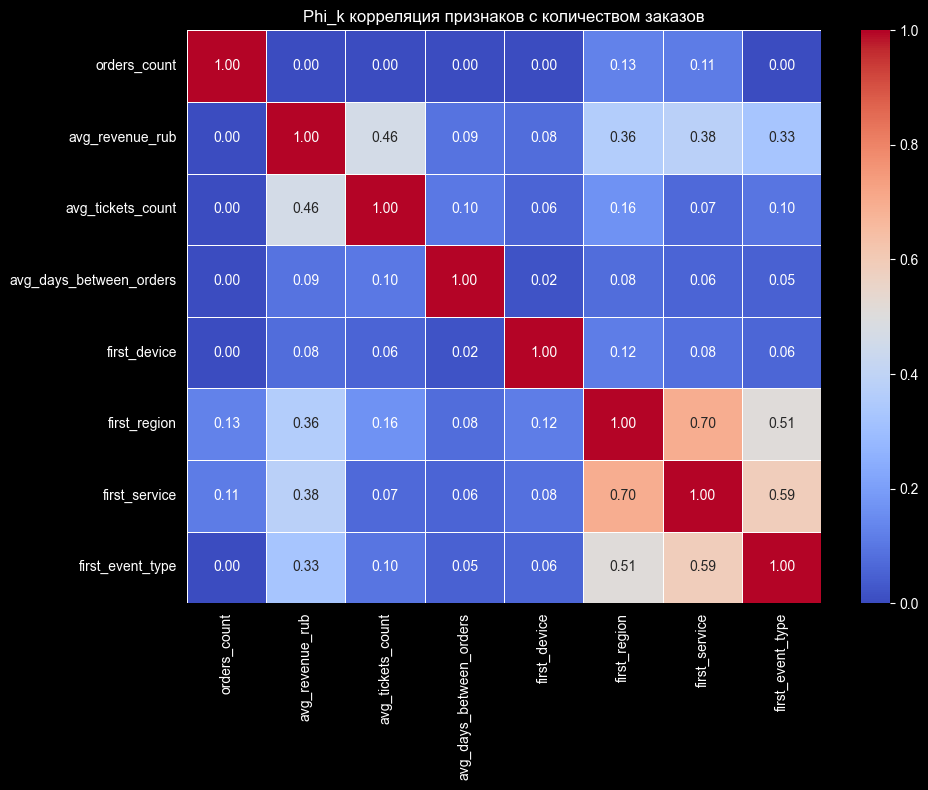

In [203]:
cols_for_corr = [
    'orders_count',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders',
    'first_device',
    'first_region',
    'first_service',
    'first_event_type'
]

corr_df = user_profile[cols_for_corr].copy()

interval_cols = [
    'orders_count',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders'
]

phik_corr = corr_df.phik_matrix(interval_cols=interval_cols)
display(phik_corr)


plt.figure(figsize=(10, 8))
sns.heatmap(
    phik_corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Phi_k корреляция признаков с количеством заказов')
plt.tight_layout()
plt.show()


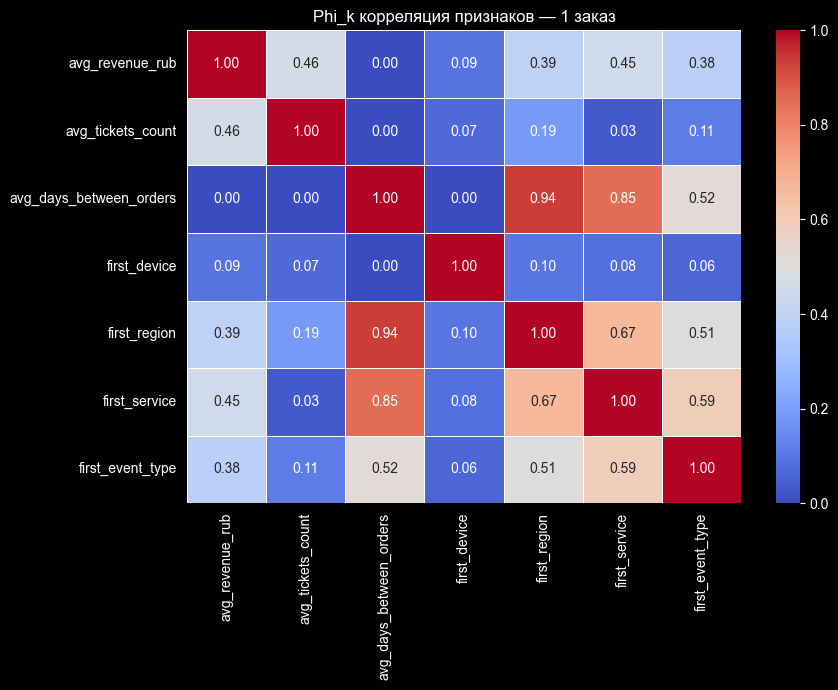

In [204]:
# Создаём сегменты по количеству заказов
user_profile['orders_segment'] = pd.cut(
    user_profile['orders_count'],
    bins=[0, 1, 4, float('inf')],
    labels=['1 заказ', '2–4 заказа', '5+ заказов'],
    right=True
)

user_profile['orders_segment'].value_counts()

interval_cols = [
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders'
]

cat_cols = [
    'first_device',
    'first_region',
    'first_service',
    'first_event_type'
]

cols_for_corr_segment = interval_cols + cat_cols

def plot_phik_for_segment(df, segment_name):
    segment_df = df[df['orders_segment'] == segment_name][cols_for_corr_segment]

    phik_corr = segment_df.phik_matrix(interval_cols=interval_cols)

    plt.figure(figsize=(9, 7))
    sns.heatmap(
        phik_corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        linewidths=0.5
    )
    plt.title(f'Phi_k корреляция признаков — {segment_name}')
    plt.tight_layout()
    plt.show()

    return phik_corr

phik_1 = plot_phik_for_segment(user_profile, '1 заказ')

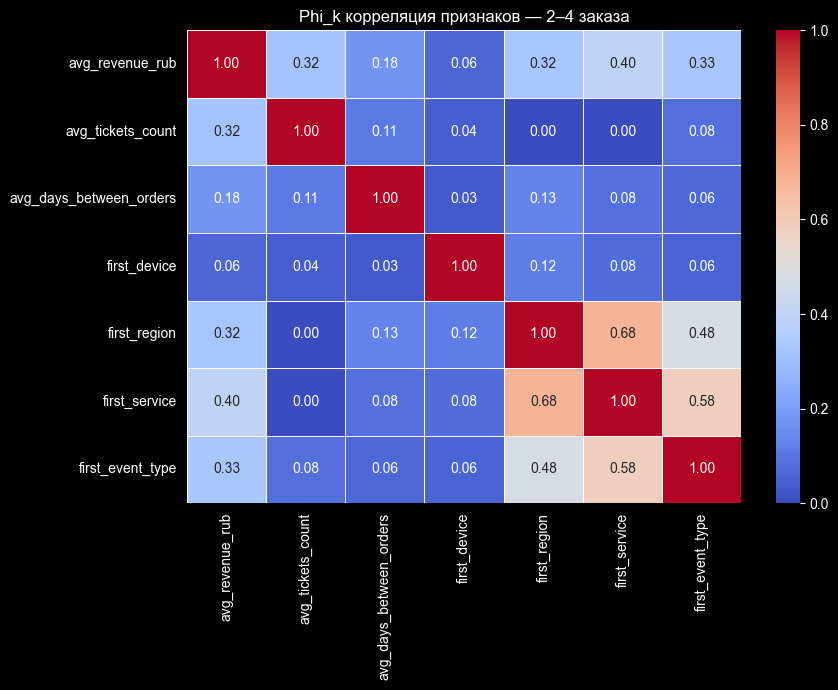

In [205]:
phik_2_4 = plot_phik_for_segment(user_profile, '2–4 заказа')

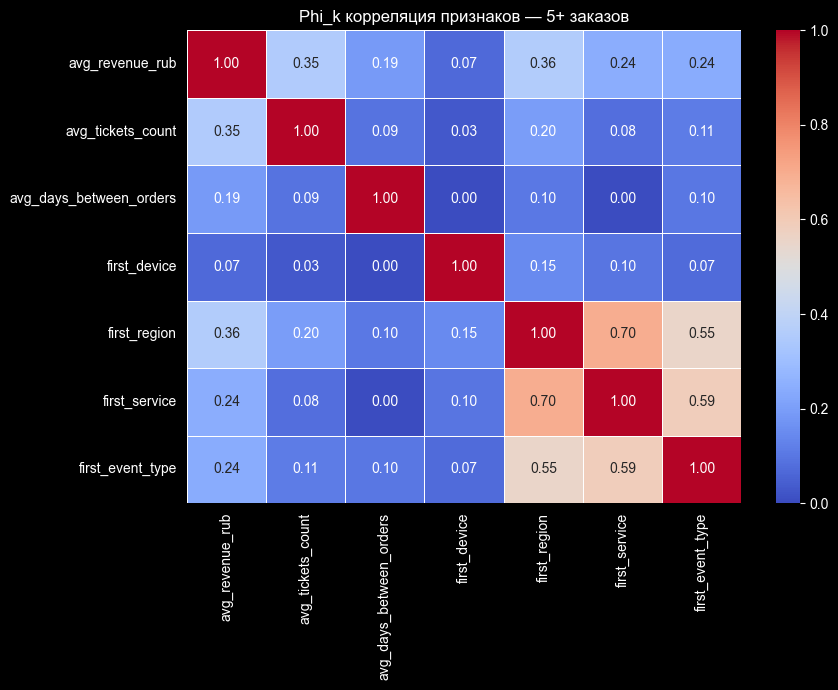

In [206]:
phik_5 = plot_phik_for_segment(user_profile, '5+ заказов')

Для анализа связи характеристик профиля пользователя с количеством заказов был использован коэффициент корреляции **phi_k**, который позволяет оценивать взаимосвязи между числовыми и категориальными признаками.

В анализ были включены следующие признаки:
 - количество заказов (`orders_count`);
 - средняя выручка с заказа (`avg_revenue_rub`);
 - среднее количество билетов в заказе (`avg_tickets_count`);
 - средний интервал между заказами (`avg_days_between_orders`);
 - устройство первого заказа (`first_device`);
 - регион первого заказа (`first_region`);
 - билетный оператор первого заказа (`first_service`);
 - тип первого мероприятия (`first_event_type`).

Для числовых признаков был явно задан параметр `interval_cols`.

---

**Корреляция признаков с количеством заказов (общая выборка)**

На первом этапе был рассчитан коэффициент `phi_k` между всеми признаками и количеством заказов (`orders_count`) по всей выборке.

**Основные наблюдения:**
 - Значения корреляции между `orders_count` и остальными признаками близки к **нулю**.
 - Это связано с особенностями распределения `orders_count`: в данных доминируют пользователи с небольшим числом заказов, что  снижает чувствительность корреляционного анализа.
 - При этом между самими признаками наблюдаются заметные зависимости:
   - между регионом первого заказа и билетным оператором;
   - между билетным оператором и типом первого мероприятия;
   - между средней выручкой и средним количеством билетов в заказе.

Таким образом, анализ по всей выборке не позволяет корректно выявить факторы, связанные с числом заказов.

---

**Корреляционный анализ с сегментацией по числу заказов**

Чтобы избежать влияния перекоса распределения `orders_count`, пользователи были разделены на следующие сегменты:
 - **1 заказ**;
 - **2–4 заказа**;
 - **5 и более заказов**.

Для каждого сегмента был отдельно рассчитан коэффициент phi_k между признаками профиля пользователя.

---

**Сегмент: 1 заказ**

- Корреляции между признаками выражены наиболее сильно.
- Наблюдаются высокие значения корреляции между:
  - регионом первого заказа;
  - билетным оператором;
  - типом первого мероприятия.
- Также заметна связь между средним интервалом между заказами и категориальными признаками.
- Это указывает на то, что поведение пользователей с одним заказом в значительной степени определяется характеристиками первой покупки.

---

**Сегмент: 2–4 заказа**

- Корреляции становятся более умеренными.
- Связи между признаками первого заказа сохраняются, но ослабевают.
- Поведенческие метрики (выручка, количество билетов, интервалы между заказами) демонстрируют слабые или умеренные связи с категориальными признаками.
- Пользовательское поведение становится более устойчивым и менее зависимым от точки входа.

---

**Сегмент: 5 и более заказов**

- Корреляционная структура наиболее стабильна.
- Основные зависимости сохраняются между признаками первого заказа:
  - регион;
  - билетный оператор;
  - тип мероприятия.
- Поведенческие метрики имеют слабую связь с категориальными признаками.
- Это свидетельствует о том, что для лояльных пользователей количество заказов определяется совокупностью пользовательского опыта, а не отдельными характеристиками первой покупки.

---

**Вывод**
- Прямой корреляционный анализ количества заказов по всей выборке не выявляет значимых зависимостей из-за сильного перекоса распределения `orders_count`.
- Сегментация пользователей по числу заказов позволяет выявить скрытые взаимосвязи между признаками.
- Наиболее устойчивые и сильные связи наблюдаются между характеристиками первого заказа (регион, билетный оператор, тип мероприятия).
- Поведенческие метрики слабо связаны с количеством заказов напрямую, но отражают изменение поведения пользователей по мере роста лояльности.
- Полученные результаты подтверждают целесообразность использования признаков первого заказа и поведенческих характеристик при построении моделей прогнозирования количества заказов и возврата пользователей.


## Общий вывод и рекомендации

### Общий вывод

В рамках проекта был проведён комплексный анализ лояльности пользователей сервиса **Яндекс Афиша** на основе данных о заказах, мероприятиях и пользовательском поведении.

**Данные и подготовка**
- Проанализирован датасет объёмом **290 611 заказов** и **21 854 уникальных пользователя**.
- Выручка была приведена к единой валюте (рубли) с использованием официальных курсов тенге.
- Пропуски в `days_since_prev` корректно интерпретированы как пользователи с одним заказом.
- Типы данных оптимизированы, объём памяти сокращён с ~216 МБ до ~60 МБ.
- Выбросы по выручке отфильтрованы по **99-му перцентилю** (удалено <1% заказов), что повысило устойчивость статистических выводов.

---

### Ключевые результаты анализа

**1. Общая структура лояльности**
- **61,7% пользователей** совершают **2 и более заказов**.
- **≈29% пользователей** совершают **5 и более заказов**.
- Распределение числа заказов сильно асимметрично: основную массу формируют пользователи с 1–5 заказами, при наличии небольшой группы сверхактивных пользователей.

---

**2. Признаки первого заказа**
- Наиболее частая «точка входа» — **концерты** (~44% пользователей).
- **Мобильные устройства** — основной канал первого заказа (~83%).
- Возвраты выше среднего наблюдаются у пользователей, начавших с:
  - театра;
  - выставок;
  - концертов.
- Спортивные мероприятия и «ёлки» демонстрируют более низкую долю возвратов.
- Пользователи, начавшие с **десктопа**, возвращаются немного чаще, чем мобильные.

---

**3. Финансовые и количественные характеристики**
- Средняя выручка с заказа **не растёт** с увеличением лояльности, однако:
  - у лояльных пользователей распределение выручки более стабильное;
  - пользователи с одним заказом чаще находятся в сегменте низкой выручки.
- Среднее количество билетов оказывает **нелинейное влияние**:
  - наиболее лояльный сегмент — **2–3 билета**;
  - 1–2 билета и 5+ билетов связаны с более низкой вероятностью возврата.

---

**4. Временные характеристики**
- День недели первого заказа оказывает **слабое влияние** на удержание.
  - Небольшое преимущество у выходных и начала недели.
- **Средний интервал между заказами — один из ключевых факторов лояльности**:
  - пользователи с 5+ заказами покупают в среднем раз в **~9–10 дней**;
  - пользователи с 2–4 заказами — раз в **~21 день**;
  - рост интервала между заказами является индикатором снижения вовлечённости.

---

**5. Корреляционный анализ (phi_k)**
- Прямая корреляция `orders_count` с признаками по всей выборке близка к нулю из-за перекоса распределения.
- Сегментация по числу заказов выявила устойчивые зависимости:
  - сильные связи между **регионом**, **билетным оператором** и **типом первого мероприятия**;
  - поведенческие метрики (выручка, билеты, интервалы) отражают изменение поведения по мере роста лояльности, но не напрямую определяют число заказов.
- Для лояльных пользователей (5+) влияние точки входа ослабевает — поведение определяется накопленным опытом.

---

### Итоговые выводы

- Лояльность пользователей формируется **не за счёт роста среднего чека**, а за счёт **регулярности и стабильности покупок**.
- Наиболее информативные признаки:
  - тип первого мероприятия;
  - средний интервал между заказами;
  - среднее количество билетов (с оптимумом 2–3).
- Регион и билетный оператор важны, но интерпретировать их необходимо **с учётом размера сегмента**.

---

### Рекомендации для команды маркетинга

**1. Фокус на успешные точки входа**
- Усиливать продвижение **культурных мероприятий** (театр, выставки, концерты) как первых покупок.
- Использовать их как основной канал привлечения новых пользователей с высокой вероятностью возврата.

**2. Работа с интервалами между заказами**
- Внедрить триггерные коммуникации (push / email):
  - при увеличении интервала между покупками;
  - в диапазоне **10–20 дней** после заказа.
- Рассматривать рост `avg_days_between_orders` как сигнал риска оттока.

**3. Сегментация по количеству билетов**
- Таргетировать сегмент **2–3 билета** как наиболее лояльный.
- Для сегмента **1–2 билета** — усиливать вовлечение (подборки, рекомендации, персональные предложения).
- Сегмент **5+ билетов** рассматривать отдельно (групповые и разовые сценарии), не смешивая с обычными пользователями.

**4. Учёт устройства**
- Десктоп-пользователей использовать для более сложных и «осознанных» сценариев (подборки, пакеты, премиальные предложения).
- Для мобильных — фокус на простоту, скорость и повторяемость покупок.

**5. Использование признаков в моделях**
- При построении моделей прогнозирования возврата и LTV:
  - обязательно включать `avg_days_between_orders`, `avg_tickets_count`, тип первого мероприятия;
  - использовать сегментацию по числу заказов, а не «сырое» `orders_count`.

---

**Финальный вывод:**
Наиболее перспективная стратегия роста лояльности — не увеличение среднего чека, а формирование привычки регулярных покупок через правильную точку входа, контроль интервалов между заказами и работу с вовлечёнными сегментами пользователей.


## Финализация проекта и публикация в Git


**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**